# Fallback - Insert Retention Scores (RedShift)
* StelllarAlgo Data Science
* Ryan Kazmerik & Nakisa Rad
* Mar 7, 2022

In [22]:
import awswrangler as wr
import boto3
import getpass
import matplotlib.pyplot as plt
import pandas as pd
import pyodbc

from datetime import datetime
from pycaret.classification import *

In [7]:
! aws sso login --profile Stellaralgo-DataScienceAdmin

Attempting to automatically open the SSO authorization page in your default browser.
If the browser does not open or you wish to use a different device to authorize this request, open the following URL:

https://device.sso.us-east-1.amazonaws.com/

Then enter the code:

MFPG-DRCJ
Successully logged into Start URL: https://stellaralgo.awsapps.com/start


### Let's connect to our MSSQL PROD environment and run a stored proc to get our dataset:

In [27]:
# connect to SQL Server.
SERVER = '34.206.73.189' 
DATABASE = 'datascience' 
USERNAME = 'dsAdminWrite' 
PASSWORD = getpass.getpass(prompt='Enter your password')
CNXN = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+SERVER+';DATABASE='+DATABASE+';UID='+USERNAME+';PWD='+ PASSWORD)

In [28]:
CLUSTER = "qa-app"
DBNAME = "stlrMLS"
LKUPCLIENTID = 13

In [29]:
cursor = CNXN.cursor()

storedProc = (
    f"""Exec {DBNAME}.ds.getRetentionScoringModelData {LKUPCLIENTID}"""
)

df = pd.read_sql(storedProc, CNXN)

# apply some data transformations
df["year"] = pd.to_numeric(df["year"])

CNXN.commit()
cursor.close()

print(f"TOTAL ROWS: {df.shape[0]}")
df.head()



TOTAL ROWS: 16153


,lkupClientId,dimCustomerMasterId,customerNumber,year,productGrouping,totalSpent,recentDate,attendancePercent,renewedBeforeDays,isBuyer,...,maritalStatus,lengthOfResidenceInYrs,annualHHIncome,education,urbanicity,credits_after_refund,is_Lockdown,NumberofGamesPerSeason,CNTPostponedGames,isNextYear_Buyer
0,13,463639507,AXS-9063648,2017,Full Season,774.0,2017-10-22,0.764706,120,TRUE,...,1,None,None,None,None,0.0,0,17,None,1
1,13,463639520,AXS-8026589,2017,Full Season,1026.0,2017-10-22,0.823529,215,TRUE,...,1,None,None,None,None,0.0,0,17,None,1
2,13,463639568,AXS-8026390,2017,Full Season,1359.0,2017-10-11,0.588235,215,TRUE,...,1,None,None,None,None,0.0,0,17,None,1
3,13,463639948,AXS-8026663,2017,Full Season,1732.5,2017-10-22,0.941176,229,TRUE,...,1,None,None,None,None,0.0,0,17,None,1
4,13,463640455,AXS-10548666,2017,Full Season,474.0,2017-09-30,1.000000,3,TRUE,...,1,None,None,None,None,0.0,0,17,None,0


### We should specify the features used in our model:

In [30]:
# choose the features for the stellar base retention model
features = [
    "dimCustomerMasterId",
    "attendancePercent",
    "distToVenue",
    "isNextYear_Buyer",
    "lkupClientId",
    "productGrouping",
    "recency",
    "recentDate",
    "source_tenure",
    "totalSpent",
    "year"
]

# copy your main dataframe
df_dataset = df

# choose the features & train year & test year
df_dataset = df_dataset[features]
df_dataset["year"] = pd.to_numeric(df_dataset["year"])
df_dataset = df_dataset.loc[df_dataset["year"] <= 2021]

df_train = df_dataset.sample(frac=0.85, random_state=786)
df_eval = df_dataset.drop(df_train.index)

df_train.reset_index(drop=True, inplace=True)
df_eval.reset_index(drop=True, inplace=True)

# print out the number of records for training and eval
print('Data for Modeling: ' + str(df_train.shape))
print('Unseen Data For Predictions: ' + str(df_eval.shape), end="\n\n")

Data for Modeling: (11474, 11)
Unseen Data For Predictions: (2025, 11)



### Now we can model the data using a binary classification prediction for the isnextyear_buyer field to see how likely a customer is to re-purchase.

In [31]:
setup(
    data= df_train, 
    target="isNextYear_Buyer", 
    train_size = 0.85,
    data_split_shuffle=True,
    ignore_features=[
        "dimCustomerMasterId",
        "lkupClientId",
        "productGrouping",
        "recentDate",
        "year"
    ],
    silent=True,
    verbose=False,
    numeric_features=[
        "attendancePercent",
        "distToVenue",
        "recency",
        "source_tenure",
        "totalSpent"
    ]
);

### The evaluation output prints a score grid that shows average Accuracy, AUC, Recall, Precision, F1 and Kappa accross the folds (10 by default) along with training time:

In [32]:
model_matrix = compare_models(
    fold= 10,
    include= ["xgboost"],
    probability_threshold= 0.75
)

final_model = finalize_model(model_matrix)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.6806,0.7785,0.6371,0.8365,0.7232,0.3615,0.3806,0.9810


/opt/miniconda3/envs/stellar/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/miniconda3/envs/stellar/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/miniconda3/envs/stellar/lib/python3.8/site-packages/xgboost

### Let's load in our 2021 season data and get retention scores using the model:

In [33]:
df_inference = df.loc[df["year"] >= 2022]
df_inference = df_inference.fillna(0)
df_inference = df_inference[features]

df_inference.shape

(2654, 11)

In [34]:
df_predictions = (predict_model(final_model, data=df_inference, raw_score=True))
df_predictions = df_predictions[df_predictions["Score_1"] >= 0.025]

df_predictions.head()

,dimCustomerMasterId,attendancePercent,distToVenue,isNextYear_Buyer,lkupClientId,productGrouping,recency,recentDate,source_tenure,totalSpent,year,Label,Score_0,Score_1
13499,379792931,0.500000,165.9718,0,13,Partial Plan,1,2022-02-27,29,28.0,2022,0,0.8986,0.1014
13500,379799351,0.642857,74.5200,0,13,Full Season,1,2022-04-30,624,14000.0,2022,0,0.6649,0.3351
13501,379800946,0.666667,165.9718,0,13,Full Season,1,2022-04-16,259,212.0,2022,0,0.9448,0.0552
13502,379806224,0.714286,273.7400,0,13,Full Season,1,2022-04-16,309,249.0,2022,0,0.7203,0.2797
13503,463639491,1.000000,15.9000,0,13,Partial Plan,0,2022-03-12,1299,14.0,2022,1,0.0082,0.9918


### We can create some histograms to visualize each model distribution:

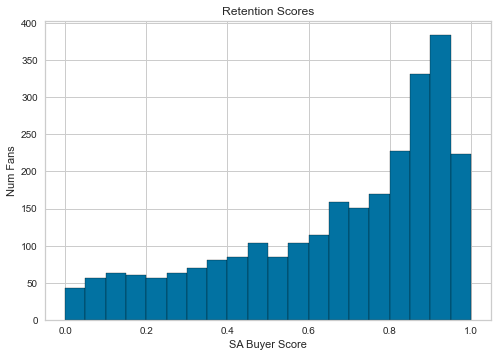

In [35]:
plt.title("Retention Scores")
plt.ylabel("Num Fans")
plt.xlabel("SA Buyer Score")
plt.hist(df_predictions["Score_1"], bins=20, edgecolor="black", range=(0,1))
                            
plt.show()

### We can also see how many purchases there are in each range of scores:

In [36]:
df_predictions["Score_1"].value_counts(bins=np.arange(0, 1.05, 0.05)).sort_index(ascending=False)

(0.95, 1.0]       224
(0.9, 0.95]       384
(0.85, 0.9]       331
(0.8, 0.85]       228
(0.75, 0.8]       170
(0.7, 0.75]       151
(0.65, 0.7]       159
(0.6, 0.65]       115
(0.55, 0.6]       103
(0.5, 0.55]        84
(0.45, 0.5]       105
(0.4, 0.45]        85
(0.35, 0.4]        81
(0.3, 0.35]        70
(0.25, 0.3]        63
(0.2, 0.25]        56
(0.15, 0.2]        60
(0.1, 0.15]        63
(0.05, 0.1]        57
(-0.001, 0.05]     43
Name: Score_1, dtype: int64

### Now we can create a session and client to RedShift, and create a new connection using AWS wrangler:

In [37]:
session = boto3.setup_default_session(profile_name='Stellaralgo-DataScienceAdmin')
client = boto3.client('redshift')
    
conn = wr.data_api.redshift.connect(
    cluster_id = CLUSTER,
    database = DBNAME.lower(),
    db_user = "admin"
)

print("CREDENTIALS RETRIEVED SUCCESSFULLY!")

CREDENTIALS RETRIEVED SUCCESSFULLY!


### Insert the new scores into the customerretentionscores table in batches:

In [38]:
batch_size = 100
df_predictions_list = [
    df_predictions[i:i + batch_size]
    for i in range(0, df_predictions.shape[0], batch_size)
]

print(f"INSERTING {len(df_predictions)} NEW RETENTION SCORES TO DATABASE: {DBNAME} ({LKUPCLIENTID})")

fields = f"""
INSERT INTO {DBNAME}.dw.customerretentionscores (
    attendancePercentage,
    dimcustomermasterid,
    scoredate,
    lkupclientid,
    mostrecentattendance,
    product,
    sascore,
    seasonyear,
    tenuredays
) VALUES """


for i, df_prediction_batch in enumerate(df_predictions_list):

    values_list = []
    for index, row in (df_prediction_batch.iterrows()):
        
        values = f"""
            (
                {str(row.attendancePercent)},
                {str(row.dimCustomerMasterId)},
                '{str(datetime.now().strftime("%Y-%m-%d"))}',
                {str(row.lkupClientId)},
                '{str(row.recentDate)}',
                '{str(row.productGrouping)}',
                {str(round((row.Score_1*100),4))},
                {str(row.year)},
                {str(row.source_tenure)}
            )"""

        values_list.append(values)

    insert_statement = fields + ",".join(values_list)+";"

    wr.data_api.redshift.read_sql_query(
        sql = insert_statement, 
        con = conn
    )
        
    print(f" > INSERTED BATCH {i+1} : ROWS {i*batch_size + 1} - {i*batch_size + len(values_list)}")

print("RETENTION SCORE INSERTS COMPLETED")

INSERTING 2632 NEW RETENTION SCORES TO DATABASE: stlrMLS (13)
 > INSERTED BATCH 1 : ROWS 1 - 100
 > INSERTED BATCH 2 : ROWS 101 - 200
 > INSERTED BATCH 3 : ROWS 201 - 300
 > INSERTED BATCH 4 : ROWS 301 - 400
 > INSERTED BATCH 5 : ROWS 401 - 500
 > INSERTED BATCH 6 : ROWS 501 - 600
 > INSERTED BATCH 7 : ROWS 601 - 700
 > INSERTED BATCH 8 : ROWS 701 - 800
 > INSERTED BATCH 9 : ROWS 801 - 900
 > INSERTED BATCH 10 : ROWS 901 - 1000
 > INSERTED BATCH 11 : ROWS 1001 - 1100
 > INSERTED BATCH 12 : ROWS 1101 - 1200
 > INSERTED BATCH 13 : ROWS 1201 - 1300
 > INSERTED BATCH 14 : ROWS 1301 - 1400
 > INSERTED BATCH 15 : ROWS 1401 - 1500
 > INSERTED BATCH 16 : ROWS 1501 - 1600
 > INSERTED BATCH 17 : ROWS 1601 - 1700
 > INSERTED BATCH 18 : ROWS 1701 - 1800
 > INSERTED BATCH 19 : ROWS 1801 - 1900
 > INSERTED BATCH 20 : ROWS 1901 - 2000
 > INSERTED BATCH 21 : ROWS 2001 - 2100
 > INSERTED BATCH 22 : ROWS 2101 - 2200
 > INSERTED BATCH 23 : ROWS 2201 - 2300
 > INSERTED BATCH 24 : ROWS 2301 - 2400
 > INSER

### Let's query RedShift to make sure our records got into the database:

In [39]:
select_statement = f"""
    SELECT count(*), lkupclientid, MAX(scoredate) as scoredate
    FROM {DBNAME}.dw.customerretentionscores
    WHERE lkupclientid = {LKUPCLIENTID}
    GROUP BY lkupclientid
    ORDER BY scoredate DESC
"""

df_scores = wr.data_api.redshift.read_sql_query(
    sql = select_statement, 
    con = conn
)

print(f"TOTAL RECORDS: {df_scores.shape[0]}")
df_scores

TOTAL RECORDS: 1


,count,lkupclientid,scoredate
0,104545,13,2022-05-12
